### Loan Repayment Prediction

The prediction of a borrower's probability of loan repayment is essential for the lender to manage their risk profile. This is why an underwriting process is used between the loan application and loan funding stage, which involves screening applicants based on their background. The typical flow for the lifecycle of a loan is:

Borrower Applies for Loan --> Underwriting Process --> Loan Approval --> Loan is Funded --> Loan is Paid Off/Defaulted

The advent of machine learning and Big Data has allowed companies to gather more information about the borrower, including their background and behaviour. This information can be  leveraged to predict their likelihood of repayment. Hence, this project aims to assess the risk of delinquency for a given loan application AFTER the underwriting process and before the loan approval. 

This notebook is broken down into the following sections:

1. EDA
2. Feature Engineering
3. Model Training
4. Conclusion



In [318]:
## Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [319]:
## Load Data

loan_df = pd.read_csv('data/loan_shortened.csv')
payment_df = pd.read_csv('data/payment_shortened.csv')
risk_df = pd.read_csv('data/clarity_underwriting_variables.csv')

C:\Users\Zysoh\AppData\Local\Temp\ipykernel_26252\3730202882.py:5: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  risk_df = pd.read_csv('data/clarity_underwriting_variables.csv')


In [320]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

- Since the goal of the model is to investigate delinquency, we need to filter the dataframe based on loans that are funded, as unfunded loans cannot be delinquent.

In [321]:
funded = loan_df[loan_df['isFunded'] == 1]
funded['loanStatus'].value_counts()

Paid Off Loan                  11427
External Collection            11334
New Loan                        8112
Internal Collection             5564
Returned Item                   1182
Settlement Paid Off              708
Settled Bankruptcy               325
Pending Paid Off                 169
Charged Off Paid Off             159
Charged Off                        1
Settlement Pending Paid Off        1
Name: loanStatus, dtype: int64

In [322]:
unfunded = loan_df[loan_df['isFunded'] == 0]
unfunded['loanStatus'].value_counts()

Withdrawn Application        450984
Rejected                      85070
CSR Voided New Loan            1026
Credit Return Void              704
Customer Voided New Loan        504
Pending Application Fee           5
Pending Rescind                   4
Pending Application               4
Internal Collection               3
Voided New Loan                   2
Charged Off Paid Off              1
Customver Voided New Loan         1
Settled Bankruptcy                1
Name: loanStatus, dtype: int64

It is important to have an appropriate definition of "delinquency" as the model and interpretation of the data depends on it. 
We are defining delinquency based on the loan status. Delinquent loan statuses include:
- 'Settled Bankruptcy', 'Charged Off','Settlement Paid off' because the full loan is not repaid
- 'External Collection','Internal Collection','Charged Off Paid Off, 'Returned Item' because the loan was not paid on time

These columns will have a value of 1 in the Delinquent column. For a value of 0, the loan has to be fully paid and on time, so the loan status that correspond to this is "Paid Off Loan". It is important to note here that it is unclear whether or not loans with the "Paid Off Loan" could have been delinquent in the past, as these loans should also be included in the definition of "delinquent loans". This is currently outside the scope of the project, and will be cited as further things to investigate.

Furthermore, we will also be defining the term "Defaulted". A defaulted loan includes 'Settled Bankruptcy' and 'Charged Off' because the full loan is not repaid


In [323]:
delinquent_cols = ['Settled Bankruptcy', 'External Collection','Internal Collection','Charged Off Paid Off','Charged Off','Returned Item']
defaulted_cols = ['Settled Bankruptcy','Charged Off']
paid_cols = ['Paid Off Loan']
funded['Delinquent'] = funded['loanStatus'].apply(lambda x: 1 if x in delinquent_cols else (0 if x in paid_cols else np.nan))
funded['Defaulted'] = funded['loanStatus'].apply(lambda x: 1 if x in defaulted_cols else (0 if x in paid_cols else np.nan))
funded = funded.drop(columns=['isFunded', 'originated','approved'])

C:\Users\Zysoh\AppData\Local\Temp\ipykernel_26252\2586528736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['Delinquent'] = funded['loanStatus'].apply(lambda x: 1 if x in delinquent_cols else (0 if x in paid_cols else np.nan))
C:\Users\Zysoh\AppData\Local\Temp\ipykernel_26252\2586528736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funded['Defaulted'] = funded['loanStatus'].apply(lambda x: 1 if x in defaulted_cols else (0 if x in paid_cols else np.nan))


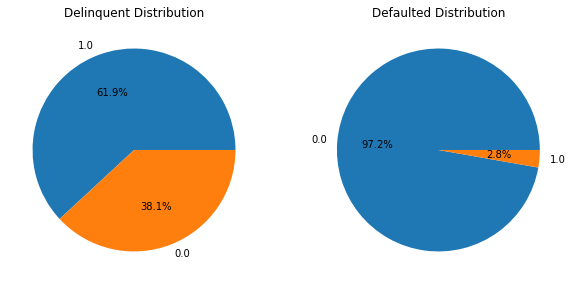

In [324]:
delinquent_counts = funded['Delinquent'].value_counts()
defaulted_counts = funded['Defaulted'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 'Delinquent' pie chart in the first subplot
axes[0].pie(delinquent_counts, labels=delinquent_counts.index, autopct='%1.1f%%')
axes[0].set_title("Delinquent Distribution")

# Plot the 'Defaulted' pie chart in the second subplot
axes[1].pie(defaulted_counts, labels=defaulted_counts.index, autopct='%1.1f%%')
axes[1].set_title("Defaulted Distribution")
plt.show()
funded = funded.drop('Defaulted',axis=1)

As we can see with this definition of Deliquency, the classes are relatively balanced, which is good as it prevents bias towards the majority class. 
The defaulted distribution on the other hand is very imbalanced.


### Preliminary EDA

#### Numerical Features

<AxesSubplot:xlabel='apr', ylabel='count'>

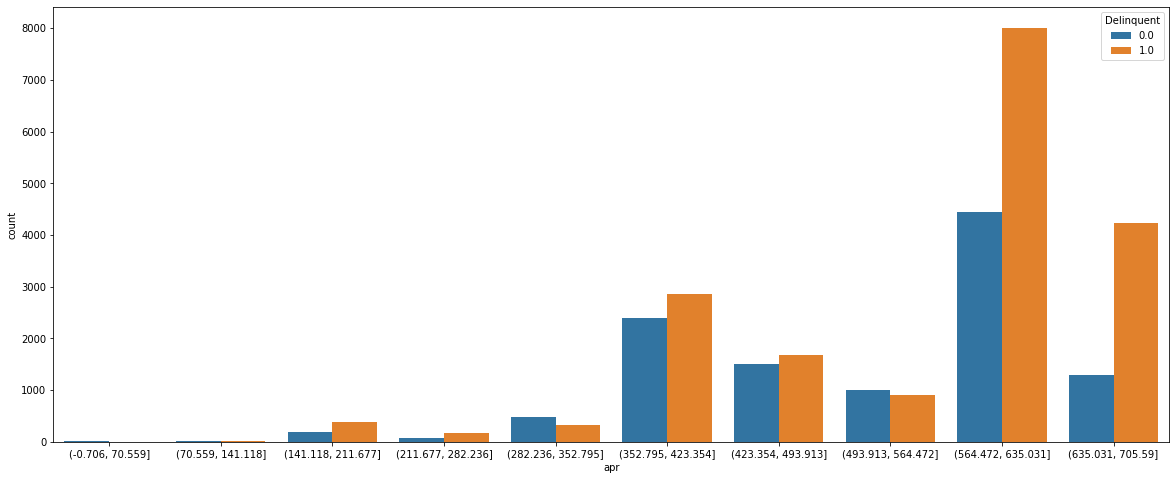

In [325]:
plt.figure(figsize=(20,8))
apr_bands = pd.cut(funded['apr'], bins=10)
sns.countplot(data=funded, x=apr_bands, hue='Delinquent')

The plot above shows at the high apr values, deliquency is much more likely
- Action: we can add apr into the features


Next up, we can merge the payment data to examine if different loan statuses have different payment behaviours

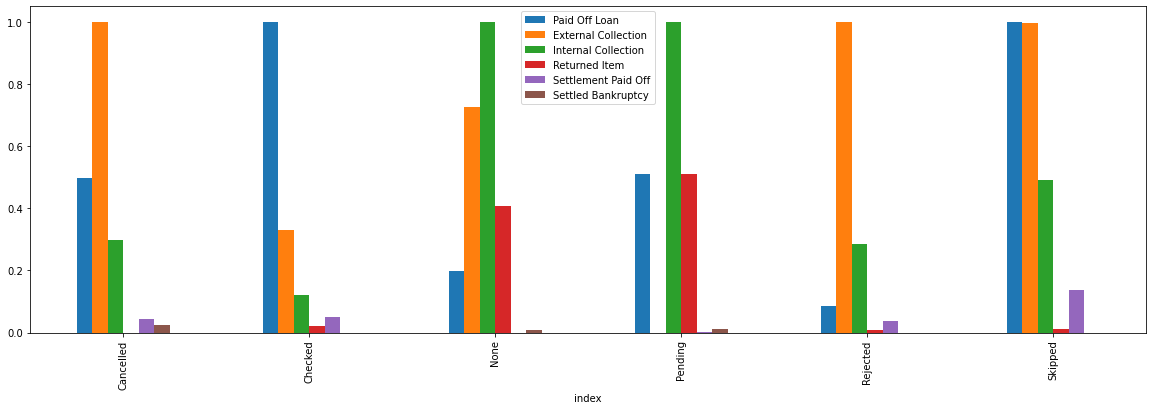

In [326]:
merged = loan_df.merge(payment_df, how = 'left', left_on = 'loanId', right_on = 'loanId')
dict1 = {
    'Paid Off Loan':merged.loc[merged['loanStatus']=='Paid Off Loan','paymentStatus'].value_counts(),
    'External Collection':merged.loc[merged['loanStatus']=='External Collection','paymentStatus'].value_counts(),
    'Internal Collection':merged.loc[merged['loanStatus']=='Internal Collection','paymentStatus'].value_counts(),
    'Returned Item':merged.loc[merged['loanStatus']=='Returned Item','paymentStatus'].value_counts(),
    'Settlement Paid Off':merged.loc[merged['loanStatus']=='Settlement Paid Off','paymentStatus'].value_counts(),
    'Settled Bankruptcy':merged.loc[merged['loanStatus']=='Settled Bankruptcy','paymentStatus'].value_counts()
}
df = pd.DataFrame(dict1).fillna(0)
# Remove the 3rd, 7th, and 8th rows
rows_to_remove = [2, 6, 7]  # Indices start from 0
df = df.reset_index().drop(rows_to_remove).set_index('index')
df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()),axis=1)

ax = df.plot.bar(figsize=(20, 6))
plt.show()


Observations
- as expected, the paid off loan has the highest number of checked payments by a considerable margin
- its interesting to see as many skipped payments for paid off loan and external collection
- its interesting to see that the settled bankruptcy doesn't have rejected payments
- there is a high amount of skipped and pending payments for the paid off loan bar, implying that those payment statuses are not a good predictor of late/imcomplete loan repayments

In [327]:
merged['Delinquent'] = merged['loanStatus'].apply(lambda x: 1 if x in delinquent_cols else (0 if x in paid_cols else np.nan))
merged.loc[merged['Delinquent']==1,'paymentReturnCode'].value_counts(normalize=True)

R01       0.720634
R02       0.091271
R08       0.075145
R16       0.036050
R10       0.020426
MISSED    0.017380
R03       0.010141
RXS       0.007382
R07       0.005447
R09       0.004730
R20       0.002831
RAF       0.002078
C01       0.001756
R04       0.001218
R99       0.001003
C05       0.000609
C03       0.000394
RWC       0.000251
RUP       0.000215
C02       0.000215
R06       0.000215
RBW       0.000143
RFG       0.000108
R15       0.000108
R29       0.000108
R13       0.000072
R19       0.000036
RIR       0.000036
Name: paymentReturnCode, dtype: float64

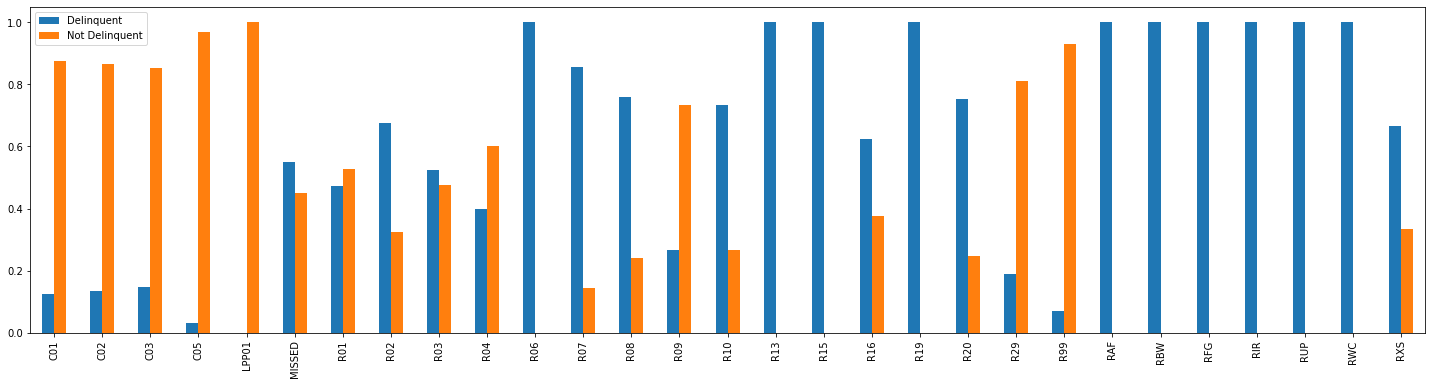

In [328]:
dict2 = {
    'Delinquent':merged.loc[merged['Delinquent']==1,'paymentReturnCode'].value_counts(normalize=True),
    'Not Delinquent':merged.loc[merged['Delinquent']==0,'paymentReturnCode'].value_counts(normalize=True),
}

df = pd.DataFrame(dict2).fillna(0)
#df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df = df.apply(lambda row: row / row.sum(), axis=1)
ax = df.plot.bar(figsize=(25, 6))

plt.show()

The figure above shows that:
- no paid off loans have the r06, r13, r15, r19, raf, rbw, rfg, rir, rup rwc payment return codes
- since, no pattern can be inferred from the definitions of these payment return codes, it is reasonable that these are extenuating circumstances
- much more delinquent accounts return the r02 code (9.1% vs 4.3%), which corresponds to account closed

#### Action
- Since the purpose of the model is to judge loan repayment BEFORE the first payment is made, payment features will be omitted from the model to prevent data leakage.

#### Categorical Features

0.6189983995732196


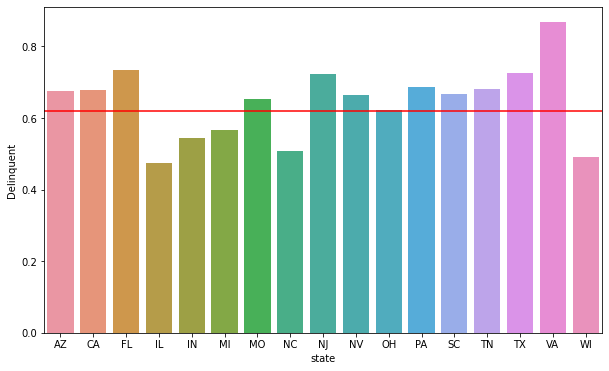

In [329]:
categorical_cols = ['payFrequency','state','leadType']
# group the data by state and compute the mean of 'delinquent' column for each group
mean_scores = funded.groupby('state')['Delinquent'].mean()

# count the occurrences of each state
state_counts = funded['state'].value_counts()

# filter the 'mean_scores' Series based on state_counts
mean_scores_filtered = mean_scores[state_counts > 500].reset_index()

overall_mean = funded['Delinquent'].mean()
print (funded['Delinquent'].mean())
mean_scores_filtered

# calculate delinquent rate by state
plt.figure(figsize=(10,6))
sns.barplot(x='state', y='Delinquent', data=mean_scores_filtered)
plt.axhline(overall_mean, color='red')
plt.show()

- the state of VA has considerably high deliquency rates
- the states of IL, NC, WI have low deliquency rates

0.6189983995732196


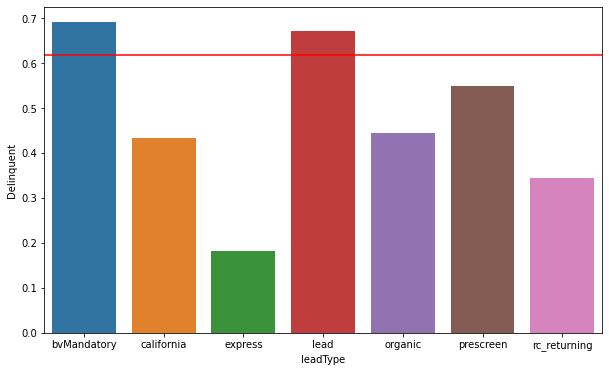

In [330]:
mean_scores = funded.groupby('leadType')['Delinquent'].mean()

# count the occurrences of each lead
lead_counts = funded['leadType'].value_counts()

# filter the 'mean_scores' Series based on lead_counts
mean_scores_filtered = mean_scores[lead_counts > 10].reset_index()

#funded.groupby('lead')['Delinquent'].mean()
overall_mean = funded['Delinquent'].mean()
print (funded['Delinquent'].mean())
mean_scores_filtered

# calculate delinquent rate by lead
plt.figure(figsize=(10,6))
sns.barplot(x='leadType', y='Delinquent', data=mean_scores_filtered)
plt.axhline(overall_mean, color='red')

- leadTypes = bvMandatory and lead have high delinquency rates
- leadTypes = express have low deliquency rates

0.6189983995732196


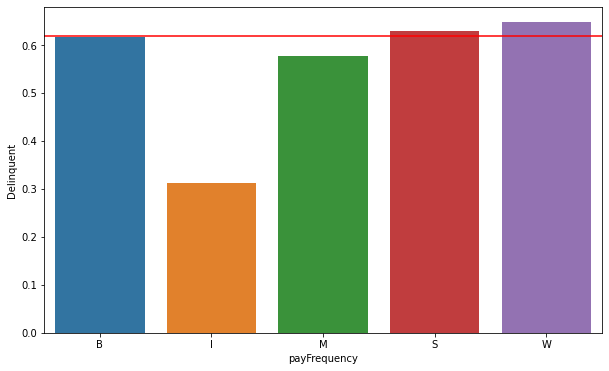

In [331]:
mean_scores = funded.groupby('payFrequency')['Delinquent'].mean()

# count the occurrences of each lead
lead_counts = funded['payFrequency'].value_counts()

# filter the 'mean_scores' Series based on lead_counts
mean_scores_filtered = mean_scores[lead_counts > 10].reset_index()

#funded.groupby('lead')['Delinquent'].mean()
overall_mean = funded['Delinquent'].mean()
print (funded['Delinquent'].mean())
mean_scores_filtered

# calculate delinquent rate by lead
plt.figure(figsize=(10,6))
sns.barplot(x='payFrequency', y='Delinquent', data=mean_scores_filtered)
plt.axhline(overall_mean, color='red')
plt.show()

- It is interesting to note that for irregular payment frequencies, the chances of being delinquent is very low

The plots above showed that there was reasonable variation of the target variable in each feature's elements. This means that these categorical variables can be included in the model. This approach can be supplemented by statistical measures in the future to quantify the variations.

### Feature Engineering

#### Creating New Features
- The year, month, day of the application and originated date
- the count of loans for each person

<AxesSubplot:xlabel='loan_count', ylabel='Count'>

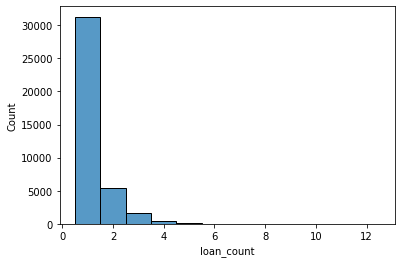

In [332]:
## Creating a new feature 
funded['applicationDate'] = pd.to_datetime(funded['applicationDate'])
funded['applicationDateYear'] = funded['applicationDate'].dt.year
funded['applicationDateMonth'] = funded['applicationDate'].dt.month
funded['applicationDateDay'] = funded['applicationDate'].dt.day

funded['originatedDate'] = pd.to_datetime(funded['originatedDate'])
funded['originatedDateYear'] = funded['originatedDate'].dt.year
funded['originatedDateMonth'] = funded['originatedDate'].dt.month
funded['originatedDateDay'] = funded['originatedDate'].dt.day

# group the DataFrame by loanId and count the number of loanids for each person
loan_count = funded.groupby('anon_ssn')['loanId'].transform('count')
funded['loan_count'] = loan_count

# create a histogram with each bar representing a single integer value
sns.histplot(data=funded, x='loan_count', discrete=True, binwidth=1)



<AxesSubplot:xlabel='loan_count', ylabel='count'>

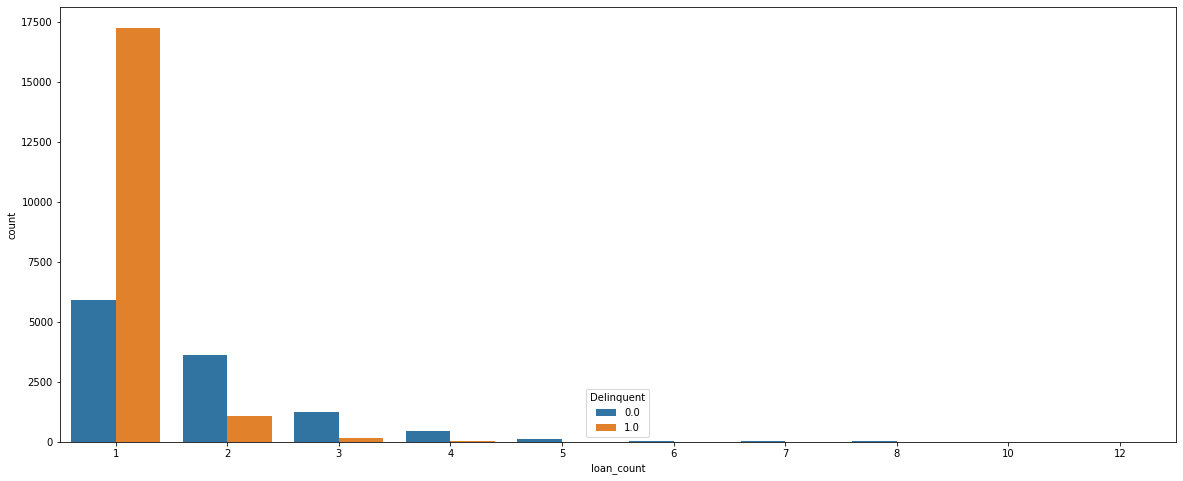

In [333]:
plt.figure(figsize=(20,8))

# Create a countplot using seaborn
sns.countplot(data=funded, x=funded['loan_count'], hue='Delinquent')

As loan count increases, the ratio of delinquent to not delinquent loans decreases
- Action: we can add loan_count to the features

#### One-Hot Encoding

- One Hot encoding is used because there is no ordinal relationship between the categorical variables

In [334]:
## One-Hot Encoding
funded = pd.get_dummies(funded, columns = categorical_cols)

In [335]:
risk_df = pd.read_csv('data/clarity_underwriting_variables.csv')
def rename_long_columns(col):
    if len(col) > 15:
        return col.split('.')[-1]
    else:
        return col
risk_df.columns = risk_df.columns.map(lambda x: rename_long_columns(x))

null_counts = risk_df.isnull().sum()

# create a list of columns with less than or equal to 500 null values
keep_cols = null_counts[null_counts <= 500].index.tolist()

# select only the columns with less than or equal to 500 null values
risk_df = risk_df[keep_cols]
risk_df = risk_df.fillna(method = 'bfill')

# create an instance of LabelEncoder
le = LabelEncoder()


object_cols = risk_df.select_dtypes(include=['object']).columns.tolist()
#print(object_cols)
object_cols.remove('underwritingid')
# select columns of type 'object' (i.e. strings)


# apply LabelEncoder to each object column in the dataframe
for col in object_cols:
    risk_df[col+'_encoded'] = le.fit_transform(risk_df[col])


# drop the original object columns
risk_df = risk_df.drop(object_cols, axis=1)


C:\Users\Zysoh\AppData\Local\Temp\ipykernel_26252\3989402806.py:1: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  risk_df = pd.read_csv('data/clarity_underwriting_variables.csv')


- Label encoder was used here as there were too many categorical features in the underwriting dataset. Since the clearfraudscore already captures a lot of the variables here, a label encoder feature was deemed sufficient.
- the features with more than 500 null values were omitted
- columns were renamed so that they were more readible

In [336]:

new_df = loan_df.merge(risk_df,how = 'left',left_on = 'clarityFraudId',right_on = 'underwritingid')
funded_risk = funded.merge(risk_df,how = 'left',left_on = 'clarityFraudId',right_on = 'underwritingid') 

In [337]:
funded_risk.columns.tolist()

['loanId',
 'anon_ssn',
 'apr',
 'applicationDate',
 'originatedDate',
 'nPaidOff',
 'loanStatus',
 'loanAmount',
 'originallyScheduledPaymentAmount',
 'leadCost',
 'fpStatus',
 'clarityFraudId',
 'hasCF',
 'Delinquent',
 'applicationDateYear',
 'applicationDateMonth',
 'applicationDateDay',
 'originatedDateYear',
 'originatedDateMonth',
 'originatedDateDay',
 'loan_count',
 'payFrequency_B',
 'payFrequency_I',
 'payFrequency_M',
 'payFrequency_S',
 'payFrequency_W',
 'state_AK',
 'state_AL',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MD',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_OH',
 'state_OK',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_WA',
 'state_WI',
 'state_

In [338]:
corrmat = funded_risk.corr()
corrmat['Delinquent'].abs().sort_values(ascending=False).head(20)

Delinquent               1.000000
loan_count               0.412377
nPaidOff                 0.208254
clearfraudscore          0.207189
leadType_organic         0.180727
leadType_bvMandatory     0.138452
apr                      0.134204
state_IL                 0.119148
applicationDateYear      0.114835
originatedDateYear       0.114260
leadType_rc_returning    0.101415
hasCF                    0.082481
threesixtyfivedaysago    0.075712
ninetydaysago            0.075432
payFrequency_I           0.075324
state_WI                 0.075196
state_VA                 0.074809
leadType_lead            0.064096
state_TX                 0.063029
thirtydaysago            0.055258
Name: Delinquent, dtype: float64

- The correlation between the features and the target is sorted above to highlight the top features to look out for. A heatmap wasnt used here as there were too many features, and for this short project, I wanted a concise way of seeing the correlation magnitudes
There should be reasonable agreement between the features shown here and the features from feature importances (model). If they are different, that means that there are a lot of non-linearities in the use case.

#### Model Training

For this use case, we will be using a Random Forest Classifier and a Gradient Boosting Classifier

Random Forest Classifier
- Robust to overfitting 
- Can handle high dimensional data
<br>
Gradient Boosting Classifier
- Higher predictive performance than Random Forest
- Effective at reducing bias

Both are better than simpler models like logistic regression because they can handle non-linearities better

In [339]:
n_dropped_rows = funded_risk.shape[0] - funded_risk.dropna().shape[0]
print(f"Dropped {n_dropped_rows} rows")
funded_risk = funded_risk.dropna()

Dropped 13989 rows


In [340]:
X = funded_risk
X = X.drop(columns = ['loanId', 'anon_ssn', 'applicationDate', 'originatedDate', 'loanStatus','fpStatus', 'clarityFraudId', 'underwritingid','Delinquent'], axis = 1)
Y = funded_risk['Delinquent']
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42)

In [341]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)
print ('The accuracy of the Random Forest Model is {}'.format(rf_accuracy))

gb_model = GradientBoostingClassifier(n_estimators=200)
gb_model.fit(X_train, y_train)
gb_accuracy = gb_model.score(X_test, y_test)
print ('The accuracy of the Gradient Boosting Model is {}'.format(gb_accuracy))

The accuracy of the Random Forest Model is 0.7817250760121619
The accuracy of the Gradient Boosting Model is 0.7903664586333813


<AxesSubplot:>

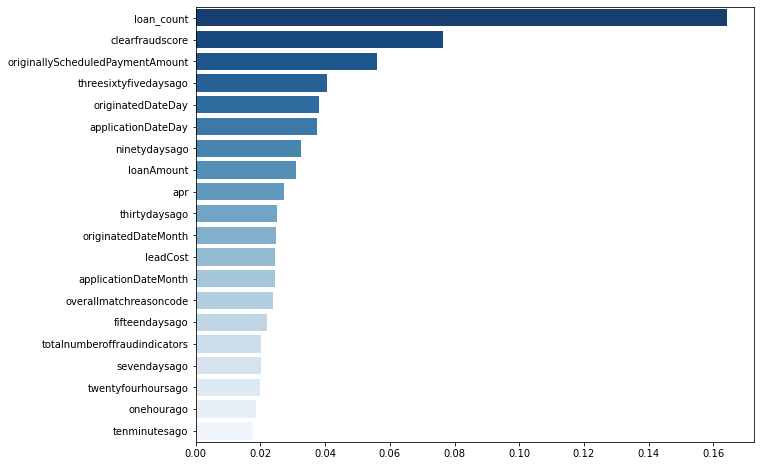

In [342]:
importances = rf_model.feature_importances_


# Sort the features by importance score in descending order
sorted_indices = np.argsort(importances)[::-1][:20]
sorted_features = X_train.columns[sorted_indices]
sorted_importances = importances[sorted_indices]

# Create a horizontal bar plot of feature importances using Seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features, palette='Blues_r')

The plot above shows the most important features for the classifier. 
- it is interesting that the most notable clearfraud indicator is "threesixtyfivedaysago" aka ".underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago": Number of unique inquiries for the consumer seen by Clarity in the last 365 days. Lets investigate the relationship below


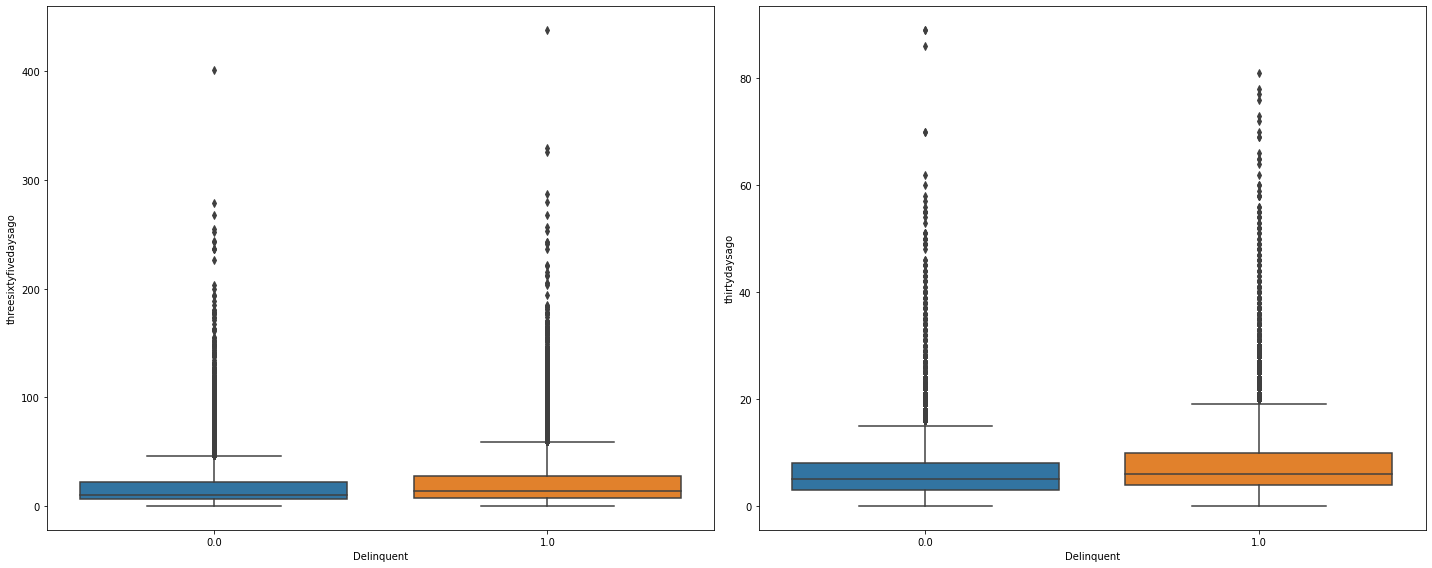

In [343]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Box plot - ago vs Delinquent
sns.boxplot(x='Delinquent', y='threesixtyfivedaysago', data=funded_risk, ax=ax1)
ax1.set_xlabel('Delinquent')
ax1.set_ylabel('threesixtyfivedaysago')

# Scatter plot - another feature vs Delinquent
sns.boxplot(x='Delinquent', y='thirtydaysago', data=funded_risk, ax=ax2)
ax2.set_xlabel('Delinquent')
ax2.set_ylabel('thirtydaysago')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

- This box plot shows that on, there are slightly more unique inquiries 365 days ago and 30 days ago respectively for delinquent loans.
- 30 days ago has more outliers in the Non-delinquent class

In [344]:
from sklearn.metrics import roc_auc_score
predicted_probabilities = rf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predicted_probabilities)
print ('The AUC for the Random Forest Model is {}'.format(auc))

predicted_probabilities = gb_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predicted_probabilities)
print ('The AUC for the Gradient Boosting Model is {}'.format(auc))

The AUC for the Random Forest Model is 0.8178130896180363
The AUC for the Gradient Boosting Model is 0.8256921439306791


In [345]:
## precision recall
from sklearn.metrics import precision_score, recall_score
y_pred = rf_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.7839572192513369
Recall: 0.9119183876586215


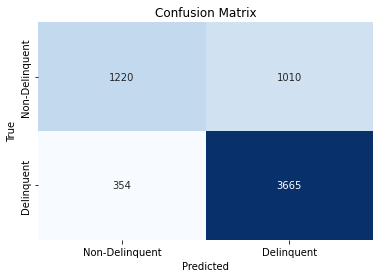

In [346]:
from sklearn.metrics import confusion_matrix


# Assuming y_test contains the true labels and y_pred contains the predicted labels
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Set labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks([0.5, 1.5], labels=["Non-Delinquent", "Delinquent"])
plt.yticks([0.5, 1.5], labels=["Non-Delinquent", "Delinquent"])

# Display the plot
plt.show()

- What we are particularly interested in this confusion matrix are the false negatives. False negatives are more important than false positives in this context because getting a false negative is potentially having a loan defaulted whereas the cost of having a false positive is not funding a loan and thereby missing out on the loan's interest & customer base.
- We can balance the false positives and false negatives by adjusting the probablity threshold for a class to be considered Delinquent

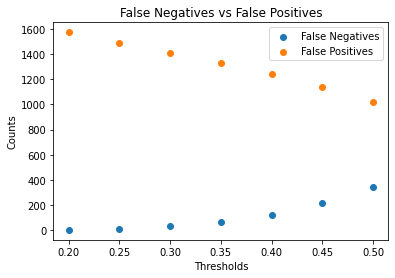

In [347]:
thresholds = [0.5,0.45,0.4,0.35,0.3,0.25,0.2]  # List of precision thresholds to loop through

false_negatives = []
false_positives = []

for threshold in thresholds:
    # Get predicted probabilities for the positive class
    proba_pos = rf_model.predict_proba(X_test)[:, 1]

    # Adjust the predictions based on the threshold
    predictions = proba_pos >= threshold

    # Get the confusion matrix for the adjusted predictions
    cm = confusion_matrix(y_test, predictions)

    # Calculate false negatives and false positives
    fn = cm[1, 0]
    fp = cm[0, 1]

    false_negatives.append(fn)
    false_positives.append(fp)

# Plot the false negatives vs false positives scatter plot

plt.scatter(thresholds, false_negatives, label='False Negatives')
plt.scatter(thresholds, false_positives, label='False Positives')
plt.xlabel('Thresholds')
plt.ylabel('Counts')
plt.title('False Negatives vs False Positives')
plt.legend()
plt.show()

From the plot above, I'd suggest selecting a decision threshold around 0.3-0.25 because
- we want to minimize false negatives as much as possible
- the slope of the blue scatter is levelling off in the 0.2-0.30 threshold area, as to only gain diminishing returns if we further decrease the threshold

#### Quantifying Risk

The risk of giving out loans not only depends on the probability that the loan will be delinquent/defaulted, it also depends on the loan amount ie
- a higher loan amount carries more risk for the lender 

In [348]:
X_test['predicted_probabilities'] = predicted_probabilities
X_test['risk_factor'] = X_test['predicted_probabilities'] * X_test['loanAmount']

### Conclusion

Using exploratory data analysis, feature engineering and machine learning, a random forest and a gradient boosting classifier model have been developed with the objective of managing risk of loan repayments. Features such as the previous loan_count and the clearfraudscore from the underwriting process stood out as the most important features. With the business context in mind - predicting the delinquent class as comprehensively as possible, the decision threshold was adjusted to minimize false negatives. This model can be employed in the approval stage by combining the loan information and underwriting process data. Loans with very high probability of delinquency or risk factor can be automatically rejected whereas loans in the gray area could warant an extra stage of human judgement. As such, the loans that are funded will have a higher chance of being sucessfully repayed, with minimal risk incurred upon the lender.

- Time Spent: 24 hours~
- Name: Zhen Yang Soh

#### Further Improvements
Some additional improvements that have not already been mentioned include: 
- Have a more objective definition of Delinquency (ie have not paid for x amount of months) --> use payment data to create the target variable values
- Use One Hot Encoding on all categorical features and use dimensionality reduction techniques to deal with the large amount of features
- Use other data like loan applicant's income, debt-to-income ratio, credit score if available
- Merge state data with location based info like state's GDP, unemployment rate, cost of living etc.
- Test more ML models and test ensemble methods: combine scores from different models
- Use cross-validation to access versatility of model
- Remove irrelevant features either through feature importances / low correlation values  or through iterative testing 
- Do missing value imputations based on their relationship with other variables

